## https://github.com/timestocome


Try using Semi-Supervised GAN to predict next Monday's Nasdaq change based on this week's movements

Semi supervised GANs use exisiting data and create false examples that pass as real examples to augment small datasets.

Stock movements are divided into 5 somewhat equal categories, large loss, small loss, stable, small gain, large gain.

Random chance gives 20% accuracy, this code can get up to 31% accuracy, a better than 50% improvement. More data, say using hourly changes one day to predict the next morning's change should perform better.

Bitcoin data, switching datasets should be easy

In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# hack to make keras work with 2*** series gpus

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [3]:

from keras.layers import (Activation, BatchNormalization, Concatenate, Dense, LeakyReLU,
                          Embedding, Flatten, Input, Multiply, Reshape)
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras.utils import print_summary
from keras.optimizers import Adam

Using TensorFlow backend.


In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from keras import backend as K

from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape)

from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

In [5]:

# silence is golden

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)


In [6]:
# data downloaded from finance.yahoo.com

bitcoin = pd.read_csv('BTC-USD.csv', parse_dates=True, index_col=0)
nasdaq = pd.read_csv('^IXIC.csv', parse_dates=True, index_col=0)



# convert dates to datetime and get day of week
#bitcoin_raw['Date'] = pd.to_datetime(bitcoin_raw['Date'])
#nasdaq_raw['Date'] = pd.to_datetime(nasdaq_raw['Date'])


# fill in missing dates for ( holidays and other closings)
bitcoin = bitcoin.asfreq('D')
nasdaq = nasdaq.asfreq('D')



# day of week
bitcoin['date'] = bitcoin.index.values
nasdaq['date'] = nasdaq.index.values


# monday == 0, sunday == 6
bitcoin['dow'] = bitcoin['date'].dt.dayofweek
nasdaq['dow'] = nasdaq['date'].dt.dayofweek


# fill in missing days with previous day's value
bitcoin = bitcoin.fillna(method='ffill')
nasdaq = nasdaq.fillna(method='ffill')



In [7]:
# see if all looks well

print(bitcoin.head())
print(nasdaq.head())
print(nasdaq.tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

                Volume       date  dow  
Date                                    
2014-09-17  21056800.0 2014-09-17    2  
2014-09-18  34483200.0 2014-09-18    3  
2014-09-19  37919700.0 2014-09-19    4  
2014-09-20  36863600.0 2014-09-20    5  
2014-09-21  26580100.0 2014-09-21    6  
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1971-02-05  100.000000  100.000000  100.000000

In [8]:
# convert to log scale and get daily change
bitcoin['log open'] = np.log(bitcoin['Open'])
nasdaq['log open'] = np.log(nasdaq['Open'])

bitcoin['dx'] = bitcoin['log open'] - bitcoin['log open'].shift(1)
nasdaq['dx'] = nasdaq['log open'] - nasdaq['log open'].shift(1)


# remove top row
bitcoin = bitcoin.iloc[1:]
nasdaq = nasdaq.iloc[1:]


print(bitcoin.head())
print(nasdaq.head())



                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   
2014-09-22  399.100006  406.915985  397.130005  402.152008  402.152008   

                Volume       date  dow  log open        dx  
Date                                                        
2014-09-18  34483200.0 2014-09-18    3  6.124377 -0.019517  
2014-09-19  37919700.0 2014-09-19    4  6.049976 -0.074401  
2014-09-20  36863600.0 2014-09-20    5  5.978058 -0.071919  
2014-09-21  26580100.0 2014-09-21    6  6.011475  0.033418  
2014-09-22  24127600.0 2014-09-22    0  5.989212 -0.022263  
                  Open        High         Low       C

In [9]:
# convert to weekly rows, starting with Monday, following Mon is the target
# use 5 days for Nasdaq, 7 for Bitcoin

def convert_to_weeks(df):

    # split into weekly rows (m-s) 
    df['weeks'] = (df['dow'].diff() < 0).cumsum()
    wkly = df.pivot('weeks', 'dow').fillna(0)

    wkly = wkly['dx']
    wkly.columns = ['M', 'T', 'W', 'R', 'F', 'Sa', 'Su']
    print(wkly.columns)

    # target = following monday
    wkly['target'] = wkly['M'].shift(-1)
    
    
    # categorize target into buckets.... try 5
    # min nasdaq ~<.1>, max ~ .1
    # #1 < -0.8, #2 -.08..-.04, #3 -.04..04, #4 .04...08, #5 > .08
    bins = [-1., -0.01, -0.001, 0.001, 0.01, 1.0]
    labels = ['lg loss', 'sm loss', 'stable', 'sm gain', 'lg gain']
    values = [0, 1, 2, 3, 4]
    wkly['bins'] = pd.cut(wkly['target'], bins=bins, labels=values)
    wkly['bins'] = wkly['bins'].astype('float')
    n_classes = len(labels)
    
    # drop first and last rows, probably not full weeks
    wkly = wkly.iloc[1:-1]

    return wkly, n_classes



nasdaq_wkly, n_classes = convert_to_weeks(nasdaq)
bitcoin_wkly, n_classes = convert_to_weeks(bitcoin)


# save ?
nasdaq_wkly.to_csv('nasdaq_wkly.csv')
bitcoin_wkly.to_csv('bitcoin_wkly.csv')



# try nasdaq first
print(nasdaq_wkly.head(20))
print(nasdaq_wkly.tail())
print(np.unique(nasdaq_wkly['bins'], return_counts=True))

Index(['M', 'T', 'W', 'R', 'F', 'Sa', 'Su'], dtype='object')
Index(['M', 'T', 'W', 'R', 'F', 'Sa', 'Su'], dtype='object')
              M         T         W         R         F   Sa   Su    target  \
weeks                                                                         
1      0.008365 -0.000794 -0.000695  0.007520  0.005897  0.0  0.0  0.000000   
2      0.000000  0.001371 -0.004413 -0.003150 -0.007125  0.0  0.0 -0.010181   
3     -0.010181  0.000401  0.009184  0.005845  0.001086  0.0  0.0  0.004332   
4      0.004332  0.000589  0.002256  0.006932  0.002138  0.0  0.0  0.011871   
5      0.011871  0.001725 -0.002589  0.001152  0.002299  0.0  0.0  0.006011   
6      0.006011  0.004082 -0.000569  0.003595 -0.001039  0.0  0.0 -0.003789   
7     -0.003789 -0.002471 -0.003908 -0.000956  0.004483  0.0  0.0  0.001236   
8      0.001236  0.002279  0.005014  0.003485  0.004878  0.0  0.0  0.002897   
9      0.002897  0.003632  0.004638  0.002957  0.000000  0.0  0.0  0.004511   
10     0.

In [10]:

# split into test, train, datasets
print(len(nasdaq_wkly), len(bitcoin_wkly))


# nasdaq has a bit more data - let's play with that one first
n_rows = len(nasdaq_wkly)
n_test = n_rows // 10
n_train = n_rows - n_test

print(n_train, n_test)

# train must come first (datewise), followed by test, followed by validate 
# otherwise there'll be information bleed
train = nasdaq_wkly[0:n_train]
test = nasdaq_wkly[n_train:n_train + n_test]


# shuffle train
train = train.sample(frac=1.)


# split into input/output - drop weekends for nasdaq
x = train[['M', 'T', 'W', 'R', 'F']]
y = train['bins'].values.reshape(-1, 1)

x_test = test[['M', 'T', 'W', 'R', 'F']]
y_test = test['bins'].values.reshape(-1, 1)




# convert to numpy arrays
x = x.to_numpy()
x_test = x_test.to_numpy()


# not a lot of data... let's see what can be done with it
print(len(train), len(test))



input_shape = x.shape
output_shape = y.shape

print(input_shape, y.shape)

2542 266
2288 254
2288 254
(2288, 5) (2288, 1)


In [11]:
# check to see data sets okay
print(x.shape, y.shape)
print(x_test.shape, y_test.shape)

n_train = len(train)
n_test = len(x_test)


# 5 for Nasdaq, 7 for Bitcoin
n_days = 5

z_dim = x.shape[1]

(2288, 5) (2288, 1)
(254, 5) (254, 1)


In [12]:
# this model uses vectors made of random input to create simulated stock daily movements for a week

def build_generator(z_dim):

    model = Sequential()

    # input to hidden
    model.add(Dense(32, input_dim=z_dim))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    
    
    # hidden to discriminator - same shape as input
    model.add(Dense(n_days))
    model.add(Activation('tanh'))
    

    return model

In [13]:
# this both sorts data into real data, fake data created by the generator
# and sorts into the 5 categories ( large loss, small loss, stable, small gain, large gain)
# training ( weight updates ) only happen when learning to sort into the 5 categories

def build_sorter(n_days, n_classes):
    
    model = Sequential()
    
    # run input through hidden layer
    model.add(Dense(64, input_dim=z_dim))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))

    
    
    # another hidden layer
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))

    
    
    # another hidden layer
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    
    
    
    # predict class
    model.add(Dense(n_classes))

    return model
    

In [14]:
# discriminator to id real/fake data
def build_discriminator(sorter):
    
    model = Sequential()
    model.add(sorter)
        
    # Transform distribution over real classes into a binary real-vs-fake pro
    def predict(x):
        # 1 - 1/Sum(e^x + 1) --- almost sigmoid function
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))

        return prediction
                               
    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))
                               
    return model

In [15]:
# classify's next trading day as high loss, low loss, stable, low gain, high gain
def build_classifier(sorter):

    # take generated or real input
    model = Sequential()
    model.add(sorter)
    model.add(Activation('softmax'))

    return model

In [16]:
# combine the models into one  model
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [17]:
# create network

sorter = build_sorter(n_days, n_classes)

# predict class ( stock movement)
classifier = build_classifier(sorter)
classifier.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print('Classifier')
print_summary(classifier)


# predict real or fake data
discriminator = build_discriminator(sorter)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print('Discriminator')
print_summary(discriminator)


# create fake data from random noise
generator = build_generator(z_dim)
print('Generator')
print_summary(generator)


# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())







Classifier
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 5)                 3525      
_________________________________________________________________
activation_4 (Activation)    (None, 5)                 0         
Total params: 3,525
Trainable params: 3,301
Non-trainable params: 224
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 5)                 3525      
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 3,525
Trainable params: 3,301
Non-trainable params: 224
_________

In [18]:
categorical_loss = []
discriminator_loss = []
generator_loss = []

losses = []
accuracies = []

iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Labels for real weekly data: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake fake data: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------
        
        # get a batch of real-labeled, real-unlabeled, fake data

        # Get a random batch of real data
        idx = np.random.randint(0, x.shape[0], batch_size)
        data_labeled = x[idx]
        labels = y[idx]
        labels = to_categorical(labels, num_classes=n_classes)
        
        
        # get a random batch of real data, remove labels
        idx = np.random.randint(0, x.shape[0], batch_size)
        data_unlabeled = x[idx]

        # Generate a batch of fake data
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_data = generator.predict(z)
        
        
        
        # Train on real labeled data
        d_loss_real_labeled, accuracy = classifier.train_on_batch(data_labeled, labels)
        
        # train on  real unlabeled data
        d_loss_real_unlabeled, acc = discriminator.train_on_batch(data_unlabeled, real)
        
        # train on generated data
        d_loss_generated, acc = discriminator.train_on_batch(gen_data, fake)

        
        d_loss = (d_loss_real_labeled + d_loss_real_unlabeled) / 2.
    
        accuracies.append(accuracy)
        categorical_loss.append(d_loss_real_labeled)
        discriminator_loss.append(d_loss)
        
        
        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake data
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_data = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)
        generator_loss.append(g_loss)
       
        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss_real_labeled, g_loss))
            accuracies.append(accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [Classifier loss: %f, acc.: %.2f%%] [G loss: %f  D loss: %f]" %
                  (iteration + 1, d_loss_real_labeled, 100.0 * accuracy, g_loss, d_loss))

            

In [19]:
# Set hyperparameters
n_epochs = 1000
batch_size = 8
sample_interval = 10

# Train the GAN for the specified number of iterations
train(n_epochs, batch_size, sample_interval)

10 [Classifier loss: 1.473166, acc.: 37.50%] [G loss: 0.152699  D loss: 0.812015]
20 [Classifier loss: 1.756484, acc.: 25.00%] [G loss: 0.173369  D loss: 0.965219]
30 [Classifier loss: 1.691232, acc.: 12.50%] [G loss: 0.194477  D loss: 0.942637]
40 [Classifier loss: 1.738122, acc.: 12.50%] [G loss: 0.216072  D loss: 0.976755]
50 [Classifier loss: 1.548070, acc.: 25.00%] [G loss: 0.238396  D loss: 0.892188]
60 [Classifier loss: 1.717070, acc.: 25.00%] [G loss: 0.260541  D loss: 0.986532]
70 [Classifier loss: 1.565503, acc.: 25.00%] [G loss: 0.282250  D loss: 0.923093]
80 [Classifier loss: 1.421533, acc.: 37.50%] [G loss: 0.302771  D loss: 0.861121]
90 [Classifier loss: 1.619888, acc.: 37.50%] [G loss: 0.325696  D loss: 0.970486]
100 [Classifier loss: 1.784204, acc.: 12.50%] [G loss: 0.348572  D loss: 1.062754]
110 [Classifier loss: 1.670893, acc.: 25.00%] [G loss: 0.369883  D loss: 1.015228]
120 [Classifier loss: 1.591300, acc.: 25.00%] [G loss: 0.393602  D loss: 0.987506]
130 [Classifi

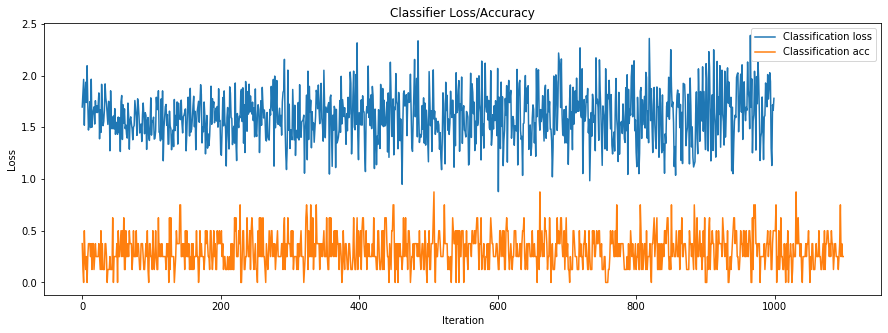

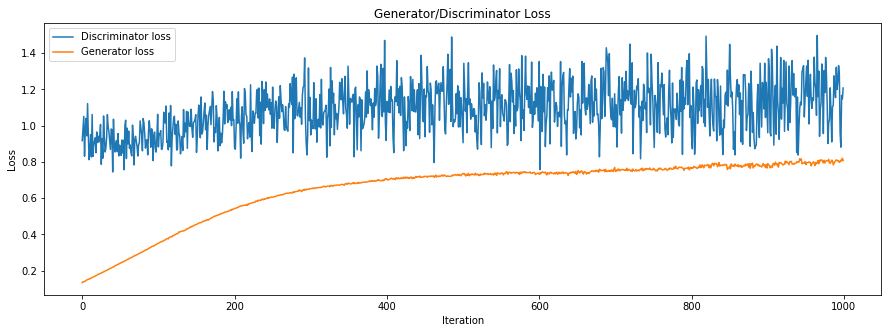

In [20]:

# Plot training losses
plt.figure(figsize=(15, 5))
plt.plot(categorical_loss, label='Classification loss')
plt.plot(accuracies, label='Classification acc')

plt.title("Classifier Loss/Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()




# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(discriminator_loss, label="Discriminator loss")
plt.plot(generator_loss, label="Generator loss")


plt.title("Generator/Discriminator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()



In [21]:
# check for total accuracy and see which categories have best/worst predictions
def compute_errors(predicted, y):

    accuracy = 0
    ll_y = 0
    sl_y = 0
    s_y = 0
    sg_y = 0
    lg_y = 0
    
    ll_match = 0
    sl_match = 0
    s_match = 0
    sg_match = 0
    lg_match = 0

    ll_p = 0
    sl_p = 0
    s_p = 0
    sg_p = 0
    lg_p = 0

    for i in range(len(predicted)):

        if predicted[i] == y[i]:  accuracy += 1

        if predicted[i] == 0: 
            ll_p += 1
            if y[i] == 0: ll_match += 1

        if predicted[i] == 1: 
            sl_p += 1
            if y[i] == 1: sl_match += 1

        if predicted[i] == 2: 
            s_p += 1
            if y[i] == 2: s_match += 1

        if predicted[i] == 3: 
            sg_p += 1
            if y[i] == 3: sg_match += 1

        if predicted[i] == 4: 
            lg_p += 1
            if y[i] == 4: lg_match += 1
    
        if y[i] == 0: ll_y += 1
        if y[i] == 1: sl_y += 1
        if y[i] == 2: s_y += 1
        if y[i] == 3: sg_y += 1
        if y[i] == 4: lg_y += 1


    print('Accuracy', accuracy/len(y))
    print('lg loss match %d of actual %d' %(ll_match, ll_y) )
    print('sm loss match %d of actual %d' %(sl_match, sl_y) )
    print('stable match %d of actual %d' %(s_match, s_y) )
    print('sm gain match %d of actual %d' %(sg_match, sg_y) )
    print('lg gain match %d of actual %d' %(lg_match, lg_y) )



In [22]:
# compute training data accuracy

predicted = classifier.predict(x)
predicted = np.argmax(predicted, axis=1)


print('Train data accuracy')
compute_errors(predicted, y)

Train data accuracy
Accuracy 0.3090034965034965
lg loss match 136 of actual 316
sm loss match 8 of actual 611
stable match 2 of actual 419
sm gain match 561 of actual 704
lg gain match 0 of actual 238


In [23]:

# compute validation data accuaracy
x = x_test
y = y_test




predicted = classifier.predict(x)
predicted = np.argmax(predicted, axis=1)


print('Test accuracy')
compute_errors(predicted, y)



Test accuracy
Accuracy 0.3110236220472441
lg loss match 12 of actual 34
sm loss match 0 of actual 55
stable match 0 of actual 48
sm gain match 67 of actual 83
lg gain match 0 of actual 34
